#Processing of the MQ sensors' logs

In this **project**, we'll build a neural network and use it to predict food degradation over time.

### CAUTION = Because the tflite-runtime version of the Raspberry is 2.5.0 we have to install the specific one here.

Check your version at Raspberry and use the same version below.

In [ ]:
!pip install tensorflow==2.5.0
import tensorflow as tf
print(tf.__version__)

In [91]:
#Importing modules
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly.

In [ ]:
data_path = 'mq_sensors_logs_feta.csv'

df_feta = pd.read_csv(data_path)
# Watch all columns
pd.options.display.max_columns = None

# Add value 0 for first day and 1 for rest.
df_feta.loc[0:1440, 'day'] = 0
df_feta.loc[1440:, 'day'] = 1

#rides_feta.head(10)
print(df_feta[1435:1445])

##Checking out the data
This dataset has logs from various different simple air sensors that are collected during food degradation over a period of time. Logs are collected in intervals of 1 minute so for one day we have 1440 entries. Check the basic set up for the [MQ-2 sensor](https://medium.com/p/5c7e2338267f) and the whole [bunch of air sensors](https://medium.com/p/b4523540f63d).

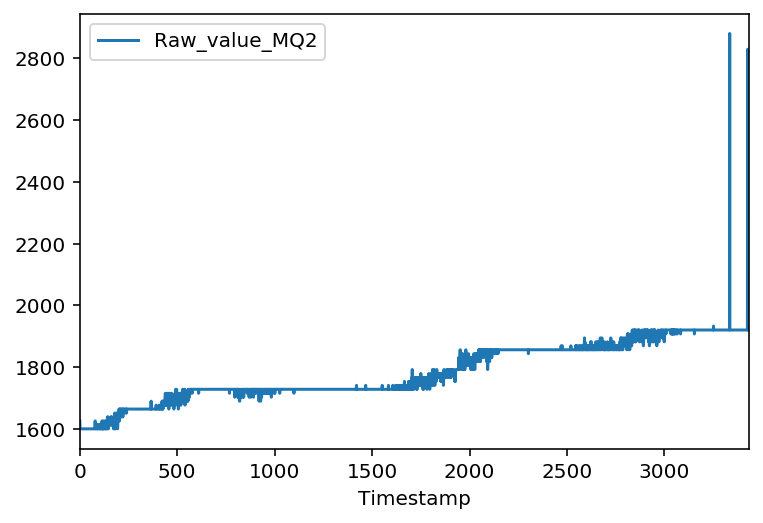

In [93]:
df_feta[:3500].plot(x='Timestamp', y='Raw_value_MQ2')

##Normalizing the values
We are dividing every log by 65472 wich is the maximum value each sensor can give. For more info read [this](https://github.com/adafruit/Adafruit_CircuitPython_MCP3xxx/blob/main/adafruit_mcp3xxx/analog_in.py#L50-L54).

In [94]:
sensor_names = ['Raw_value_MQ2', 'Raw_value_MQ3', 'Raw_value_MQ4', 'Raw_value_MQ135', 'Raw_value_MQ6', 'Raw_value_MQ7', 'Raw_value_MQ8', 'Raw_value_MQ9']
sensor_names_with_day = ['Raw_value_MQ2', 'Raw_value_MQ3', 'Raw_value_MQ4', 'Raw_value_MQ135', 'Raw_value_MQ6', 'Raw_value_MQ7', 'Raw_value_MQ8', 'Raw_value_MQ9', 'day']

MAX_VALUE = 65472
for each in sensor_names:
    df_feta.loc[:, each] = df_feta[each] / MAX_VALUE

df_feta[:10]

,Timestamp,Raw_value_MQ2,Raw_value_MQ3,Raw_value_MQ4,Raw_value_MQ135,Raw_value_MQ6,Raw_value_MQ7,Raw_value_MQ8,Raw_value_MQ9,,day
0,0,0.024829,0.098729,0.01564,0.017595,0.018573,0.028348,0.025415,0.019550,NaN,0.0
1,1,0.024438,0.087977,0.01564,0.017595,0.018573,0.028348,0.025415,0.019550,NaN,0.0
2,2,0.024438,0.090714,0.01564,0.017400,0.018573,0.028348,0.025611,0.019550,NaN,0.0
3,3,0.024438,0.080352,0.01564,0.017595,0.018573,0.028348,0.025806,0.018768,NaN,0.0
4,4,0.024438,0.077419,0.01564,0.017595,0.018573,0.028543,0.026197,0.019159,NaN,0.0
5,5,0.024438,0.084066,0.01564,0.017400,0.018573,0.028348,0.026393,0.018573,NaN,0.0
6,6,0.024438,0.089932,0.01564,0.017400,0.018573,0.028348,0.026002,0.018573,NaN,0.0
7,7,0.024438,0.102639,0.01564,0.017400,0.018573,0.028348,0.026393,0.019550,NaN,0.0
8,8,0.024438,0.091691,0.01564,0.017400,0.018573,0.028348,0.026197,0.018964,NaN,0.0
9,9,0.024438,0.095015,0.01564,0.017595,0.018573,0.028348,0.026393,0.019550,NaN,0.0


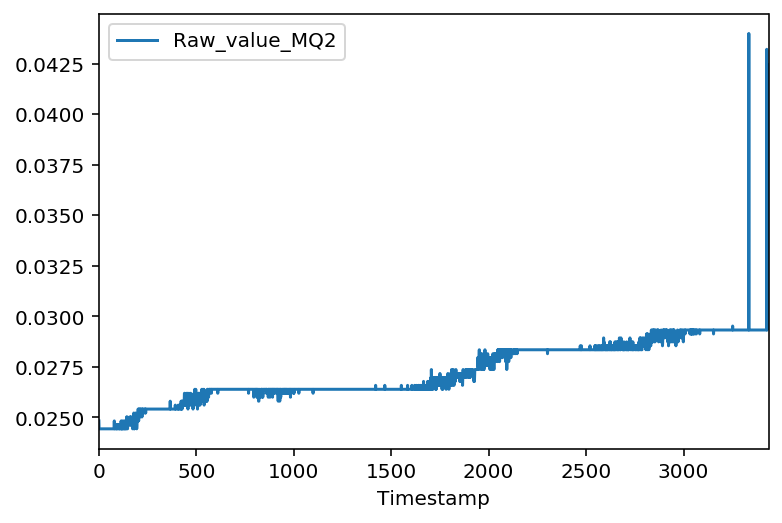

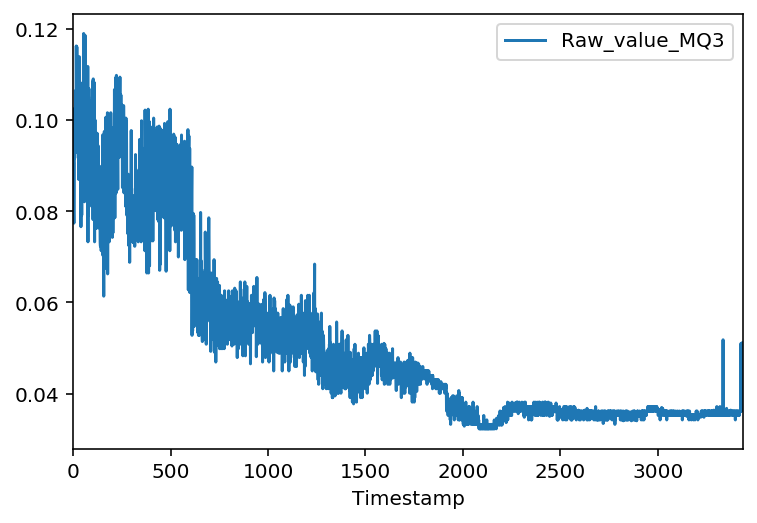

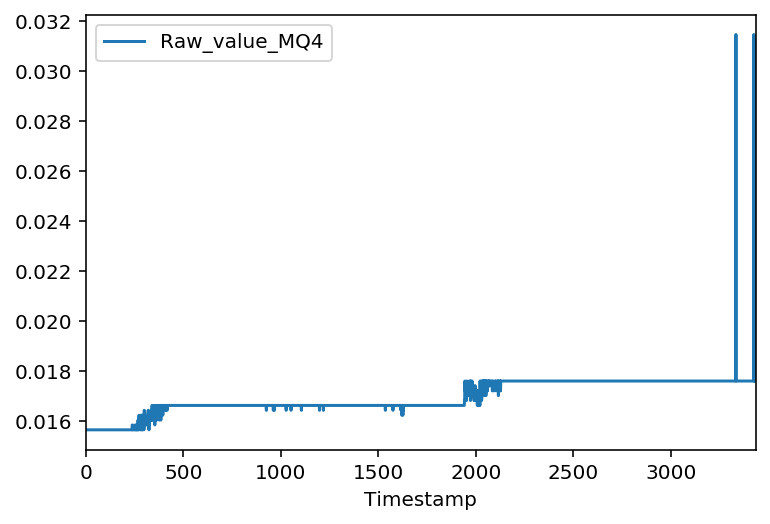

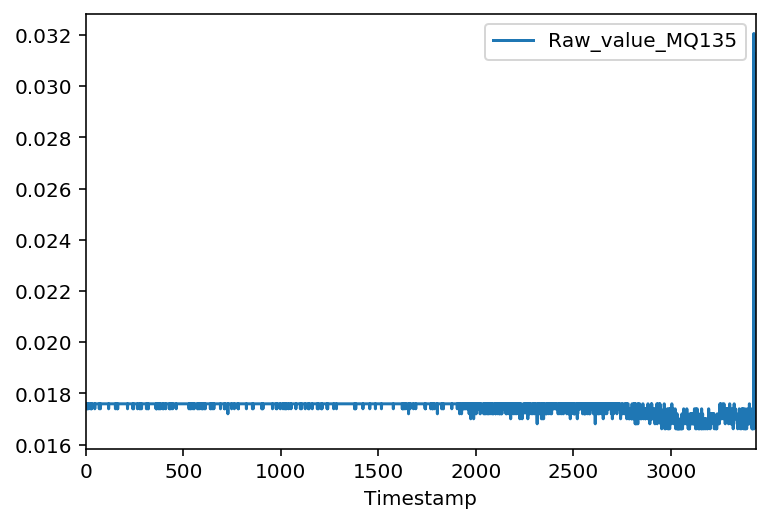

In [95]:
#Plot the diagram with normalized data
df_feta[:3500].plot(x='Timestamp', y='Raw_value_MQ2')
df_feta[:3500].plot(x='Timestamp', y='Raw_value_MQ3')
df_feta[:3500].plot(x='Timestamp', y='Raw_value_MQ4')
df_feta[:3500].plot(x='Timestamp', y='Raw_value_MQ135')

In [96]:
fields = df_feta[sensor_names_with_day]

In [97]:
#Print a dataframe with normalized values and the day
fields[1438:1450]

,Raw_value_MQ2,Raw_value_MQ3,Raw_value_MQ4,Raw_value_MQ135,Raw_value_MQ6,Raw_value_MQ7,Raw_value_MQ8,Raw_value_MQ9,day
1438,0.026393,0.042033,0.016618,0.017595,0.018573,0.02737,0.026002,0.018573,0.0
1439,0.026393,0.050831,0.016618,0.017595,0.018573,0.02737,0.026393,0.018573,0.0
1440,0.026393,0.043988,0.016618,0.017595,0.018573,0.02737,0.026197,0.018573,1.0
1441,0.026393,0.047898,0.016618,0.017595,0.018573,0.02737,0.026002,0.018573,1.0
1442,0.026393,0.041056,0.016618,0.017595,0.018573,0.02737,0.026002,0.018573,1.0
1443,0.026393,0.044966,0.016618,0.017595,0.018573,0.02737,0.026002,0.018573,1.0
1444,0.026393,0.044575,0.016618,0.017595,0.018573,0.02737,0.026197,0.018573,1.0
1445,0.026393,0.045161,0.016618,0.017595,0.018573,0.02737,0.026002,0.018573,1.0
1446,0.026393,0.044966,0.016618,0.017595,0.018573,0.02737,0.026002,0.018573,1.0
1447,0.026393,0.038123,0.016618,0.017595,0.018573,0.02737,0.026002,0.018573,1.0


### Splitting the data into training, testing, and validation sets

We'll save the data for the first 50 minutes of each day as test set and split the rest as training and validation sets.

In [98]:
# Test data for 100 minutes
test_data_first_day = fields[0:50]
test_data_second_day = fields[1440:1490]
test_data_two_days = [test_data_first_day, test_data_second_day]
# we DO NOT shuffle the test set
test_data = pd.concat(test_data_two_days)


# Now remove the test data from the data set (USE VALUES UNTIL 3000 ENTRIES)
data_first_day = fields[50:1440]
data_second_day = fields[1490:3000]
data_two_days = [data_first_day, data_second_day]
data_rest = pd.concat(data_two_days)
# SHUFFLE the dataset before splitting into training and validation and reset the index
data_rest = data_rest.sample(frac=1).reset_index(drop=True)
print(data_rest[:10])

# Separate the data into features and targets
target_field = ['day']
data_features, data_targets = data_rest.drop(target_field, axis=1), data_rest[target_field]
test_features, test_targets = test_data.drop(target_field, axis=1), test_data[target_field]


   Raw_value_MQ2  Raw_value_MQ3  Raw_value_MQ4  Raw_value_MQ135  \
0       0.028348       0.037146       0.017595         0.017595   
1       0.026197       0.055718       0.016618         0.017595   
2       0.028348       0.035191       0.017595         0.017595   
3       0.028739       0.035191       0.017595         0.017204   
4       0.028348       0.037146       0.017595         0.017595   
5       0.028348       0.036168       0.017595         0.017204   
6       0.026393       0.070772       0.016618         0.017595   
7       0.028543       0.036364       0.017595         0.017400   
8       0.028348       0.037146       0.017595         0.017595   
9       0.027370       0.041056       0.016618         0.017595   

   Raw_value_MQ6  Raw_value_MQ7  Raw_value_MQ8  Raw_value_MQ9  day  
0       0.018573       0.026588       0.025415       0.018573  1.0  
1       0.018573       0.027370       0.026197       0.018573  0.0  
2       0.018573       0.026979       0.025415       0.

In [99]:
# Create test features list.
test_features_list=[]

for row in test_features.iterrows():
    index, data = row
    test_features_list.append(data.tolist())

# Create test targets list.
test_targets_list=[]

for row in test_targets.iterrows():
    index, data = row
    test_targets_list.append(data.tolist())


# Create data features list.
data_features_list=[]

for row in data_features.iterrows():
    index, data = row
    data_features_list.append(data.tolist())

# Create data targets list.
data_targets_list=[]

for row in data_targets.iterrows():
    index, data = row
    data_targets_list.append(data.tolist())

In [100]:
'''
print(data_features_list[:10])
print(data_targets_list[:10])
print(len(data_targets_list))
'''

'\nprint(data_features_list[:10])\nprint(data_targets_list[:10])\nprint(len(data_targets_list))\n'

In [101]:
# Split into training and validation data
# Hold out the last 500 entries or so of the remaining data as a validation set
train_features, train_targets = np.array(data_features_list[:2400]), np.array(data_targets_list[:2400])
val_features, val_targets = np.array(data_features_list[2400:]), np.array(data_targets_list[2400:])
test_features, test_targets = np.array(test_features_list[:]), np.array(test_targets_list[:])

In [103]:
#Apply Principal Component Analysis
pca = PCA()
train_features = pca.fit_transform(train_features)
val_features = pca.transform(val_features)
test_features = pca.transform(test_features)

In [146]:
explained_variance = pca.explained_variance_ratio_
# Original variance ratio values
explained_variance
# Two decimals percentage presentation
print(list(map('{:.2f}%'.format,explained_variance*100)))

# the total explained variance ratio threshold
explained_variance_ratio_threshold = 0.965 #e.g. 0.965 (96.5% )
components_count = 0
principal_component_cover = 0

#Find which components will be used based on their total explained variance ratios
for variance in explained_variance:
    components_count = components_count + 1 
    principal_component_cover = principal_component_cover + variance
    if(principal_component_cover>explained_variance_ratio_threshold):
        print(principal_component_cover)             
        break
    else:
        print("principal_component_cover: ",principal_component_cover)             
        print("variance: ",variance) 
print("number_of_components: ",components_count)


['99.77%']
0.9977359479727723
true
number_of_components:  1


In [105]:
#Apply Principal Component Analysis with specific components
pca = PCA(n_components=components_count)
train_features = pca.fit_transform(train_features)
val_features = pca.transform(val_features)
test_features = pca.transform(test_features)

In [107]:
explained_variance

array([9.97735948e-01, 1.78667103e-03, 1.98916918e-04, 1.24724249e-04,
       7.65344809e-05, 4.61612488e-05, 3.10018194e-05, 4.22793477e-08])

In [108]:
'''
print(len(train_features))
print(len(train_targets))


print(len(val_features))
print(len(val_targets))
'''

'\nprint(len(train_features))\nprint(len(train_targets))\n\n\nprint(len(val_features))\nprint(len(val_targets))\n'

In [109]:
# Convert targets to categorical
print(tf.__version__)

train_targets_categorical = tf.keras.utils.to_categorical(train_targets, dtype ="uint8")
val_targets_categorical = tf.keras.utils.to_categorical(val_targets, dtype ="uint8")
test_targets_categorical = tf.keras.utils.to_categorical(test_targets, dtype ="uint8")

2.5.0


In [110]:
print(test_targets_categorical[48:53])

[[1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]]


##Build a Keras model to train the dataset.

In [111]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

model=Sequential()
model.add(Dense(256, input_dim=components_count,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

In [112]:
from tensorflow.keras.optimizers import Adam


adam = Adam(learning_rate=0.000001)
# https://keras.io/api/losses/probabilistic_losses/#categorical_crossentropy-function
model.compile(loss='categorical_crossentropy', 
             optimizer=adam, 
             metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint  

batch_size = 50
num_epochs = 500

checkpoint = ModelCheckpoint(filepath='food_quality.weights.best.h5', verbose=1, 
                               save_best_only=True)

callbacks_list = [checkpoint]

history = model.fit(train_features, train_targets_categorical, validation_data=(val_features, val_targets_categorical), batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list)

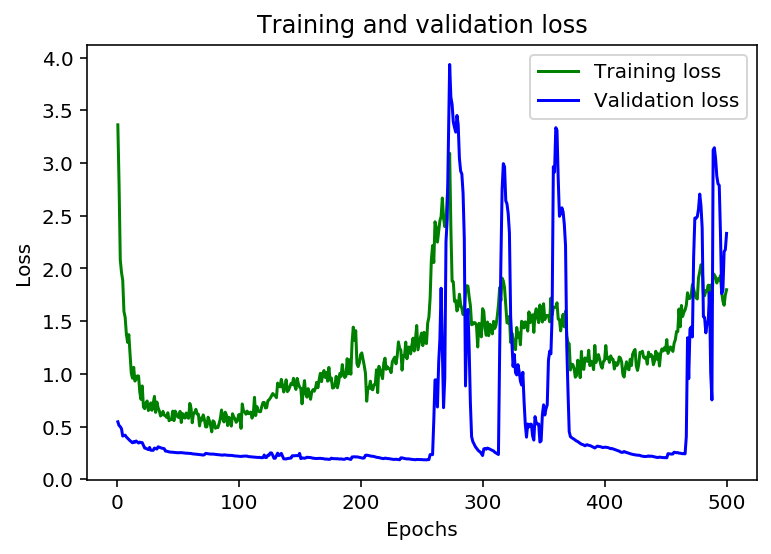

In [115]:
#Get history
history_dict = history.history
history_dict.keys()

#dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "g" is for "solid green line"
plt.plot(epochs, loss, 'g', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [116]:
#Evaluate model with the test set
print(len(test_features))
scores = model.evaluate(test_features, test_targets_categorical, verbose=1)

100
4/4 [==============================] - 0s 3ms/step - loss: 6.2213 - accuracy: 0.9500


In [126]:
test_features.shape

(100, 1)

In [ ]:
#Predict an output with one entry
# test_features = np.array(test_features_list[2])

#Manually sellect a single vector for testing the model
test_single_input_vector = test_features[2]
# test_features = np.expand_dims(test_features, axis=0)


print(test_features)
score = model.predict(test_single_input_vector, verbose=1)
print(score)
##Show the argmax label
print(tf.math.argmax(score[0]))

##Reconstruct a new model from the .h5 format

In [131]:
# reconstructed_model = keras.models.load_model("/content/food_quality.weights.best.h5")
reconstructed_model = keras.models.load_model("food_quality.weights.best.h5")

In [132]:
#Evaluate the reconstructed model with an entry from the test set
# score = reconstructed_model.predict(test_features, verbose=1)
score = reconstructed_model.predict(test_single_input_vector, verbose=1)

print(score)
print(tf.math.argmax(score[0]))

1/1 [==============================] - 0s 57ms/step
[[ 0.00191051 -0.00138178]]
tf.Tensor(0, shape=(), dtype=int64)


In [133]:
#Save the model to the saved model format
reconstructed_model.save('/content/saved_model')

INFO:tensorflow:Assets written to: /content/saved_model\assets


##Convert to tflite

In [135]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('food_model_250.tflite', 'wb') as f:
    f.write(tflite_model)

In [136]:
'''
test_features = [0.04007820136852395, 0.03734115347018573, 0.020527859237536656, 0.028347996089931573, 0.030303030303030304, 0.03616813294232649, 0.03479960899315738, 0.028347996089931573]
test_features = np.array(test_features)
test_features = np.expand_dims(test_features, axis=0)
print(test_features)
'''

'\ntest_features = [0.04007820136852395, 0.03734115347018573, 0.020527859237536656, 0.028347996089931573, 0.030303030303030304, 0.03616813294232649, 0.03479960899315738, 0.028347996089931573]\ntest_features = np.array(test_features)\ntest_features = np.expand_dims(test_features, axis=0)\nprint(test_features)\n'

In [145]:
# Load the TFLite model and allocate tensors.
# interpreter = tf.lite.Interpreter(model_path="/content/food_model_250.tflite")
interpreter = tf.lite.Interpreter(model_path="food_model_250.tflite")
interpreter.allocate_tensors()

# Get input and output tensors details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)
#Reshape input vector dimensions (2d)
test_single_input_vector=test_single_input_vector.reshape(1,len(test_single_input_vector))
# interpreter.set_tensor(input_details[0]['index'], tf.cast(test_features, tf.float32))
interpreter.set_tensor(input_details[0]['index'], tf.cast(test_single_input_vector, tf.float32))


interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[{'name': 'serving_default_dense_8_input:0', 'index': 0, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 12, 'shape': array([1, 2]), 'shape_signature': array([-1,  2]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[ 0.00191051 -0.00138178]]
